Analyzing Berkshire Hathaway's Portfolio return using the Fama-French Factors. 

Overview: This project analyzes the systemic risks that drives a portfolio's return, to help understand the underlying market factors that drives the yield of Berkshire Hathaway's investment portfolio. I will use the 5-French-Fama Factors to assess the risk of the portfolio using Least-Square Regression, identify the underlying factors for its movements, and then use an ARIMA Model to forecast future returns. 

In [32]:
import yfinance as yf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_absolute_error, mean_squared_error


In [2]:
brk = yf.download('BRK-B', start = '2009-12-30', end = '2025-08-29')
returns = brk.pct_change().dropna()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
returns.reset_index(inplace = True)

In [4]:
returns = returns.droplevel('Ticker', axis = 1)

In [5]:
ff = pd.read_csv('F-F_Research_Data_5_Factors_2x3_daily.csv')
ff

,Date,Mkt-RF,SMB,HML,RMW,CMA,RF
0,19630701,-0.67,0.00,-0.34,-0.01,0.16,0.01
1,19630702,0.79,-0.26,0.26,-0.07,-0.20,0.01
2,19630703,0.63,-0.17,-0.09,0.18,-0.34,0.01
3,19630705,0.40,0.08,-0.27,0.09,-0.34,0.01
4,19630708,-0.63,0.04,-0.18,-0.29,0.14,0.01
...,...,...,...,...,...,...,...
15640,20250822,1.70,2.25,1.17,-0.58,0.20,0.02
15641,20250825,-0.48,-0.50,0.45,0.48,-0.02,0.02
15642,20250826,0.43,0.25,0.13,-0.47,-0.46,0.02
15643,20250827,0.24,0.48,0.27,0.09,0.12,0.02


In [6]:
ff['Date'] = pd.to_datetime(ff['Date'], format = '%Y%m%d')
ff

,Date,Mkt-RF,SMB,HML,RMW,CMA,RF
0,1963-07-01,-0.67,0.00,-0.34,-0.01,0.16,0.01
1,1963-07-02,0.79,-0.26,0.26,-0.07,-0.20,0.01
2,1963-07-03,0.63,-0.17,-0.09,0.18,-0.34,0.01
3,1963-07-05,0.40,0.08,-0.27,0.09,-0.34,0.01
4,1963-07-08,-0.63,0.04,-0.18,-0.29,0.14,0.01
...,...,...,...,...,...,...,...
15640,2025-08-22,1.70,2.25,1.17,-0.58,0.20,0.02
15641,2025-08-25,-0.48,-0.50,0.45,0.48,-0.02,0.02
15642,2025-08-26,0.43,0.25,0.13,-0.47,-0.46,0.02
15643,2025-08-27,0.24,0.48,0.27,0.09,0.12,0.02


In [7]:
ff_filtered = ff[ff["Date"] >= "2009-12-31"]
ff_filtered

,Date,Mkt-RF,SMB,HML,RMW,CMA,RF
11706,2009-12-31,-1.01,-0.17,0.39,-0.45,0.17,0.00
11707,2010-01-04,1.69,0.79,1.14,-0.17,0.21,0.00
11708,2010-01-05,0.31,-0.42,1.22,-0.18,0.18,0.00
11709,2010-01-06,0.13,-0.14,0.55,-0.05,0.20,0.00
11710,2010-01-07,0.40,0.25,0.96,-0.66,0.22,0.00
...,...,...,...,...,...,...,...
15640,2025-08-22,1.70,2.25,1.17,-0.58,0.20,0.02
15641,2025-08-25,-0.48,-0.50,0.45,0.48,-0.02,0.02
15642,2025-08-26,0.43,0.25,0.13,-0.47,-0.46,0.02
15643,2025-08-27,0.24,0.48,0.27,0.09,0.12,0.02


In [8]:
returns = returns.drop('High', axis = 1)
returns = returns.drop('Low', axis = 1)
returns = returns.drop('Open', axis = 1)

In [9]:
data = pd.merge(returns, ff_filtered, on = "Date", how = "inner")

In [10]:
data = data.rename(columns = {'Close': 'BRK-B_return', 'Volume': 'BRK-B_volume'})

In [11]:
data['Excess'] = data['BRK-B_return'] - data['RF']

In [12]:
data

,Date,BRK-B_return,BRK-B_volume,Mkt-RF,SMB,HML,RMW,CMA,RF,Excess
0,2009-12-31,-0.001064,0.741071,-1.01,-0.17,0.39,-0.45,0.17,0.00,-0.001064
1,2010-01-04,0.007608,0.615385,1.69,0.79,1.14,-0.17,0.21,0.00,0.007608
2,2010-01-05,0.004832,-0.168254,0.31,-0.42,1.22,-0.18,0.18,0.00,0.004832
3,2010-01-06,-0.005110,0.343511,0.13,-0.14,0.55,-0.05,0.20,0.00,-0.005110
4,2010-01-07,0.003928,-0.144886,0.40,0.25,0.96,-0.66,0.22,0.00,0.003928
...,...,...,...,...,...,...,...,...,...,...
3934,2025-08-22,0.000839,0.364318,1.70,2.25,1.17,-0.58,0.20,0.02,-0.019161
3935,2025-08-25,-0.005767,-0.064208,-0.48,-0.50,0.45,0.48,-0.02,0.02,-0.025767
3936,2025-08-26,0.012403,1.088257,0.43,0.25,0.13,-0.47,-0.46,0.02,-0.007597
3937,2025-08-27,0.007131,-0.466273,0.24,0.48,0.27,0.09,0.12,0.02,-0.012869


In [13]:
data_train = data[data["Date"] <= "2025-08-01"]
data_test = data[data["Date"] > "2025-08-01"]

In [14]:
X = data_train[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]
X = sm.add_constant(X)
Y = data_train['Excess']    
##initializing data

In [15]:
model = sm.OLS(Y,X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Excess   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     816.9
Date:                Thu, 06 Nov 2025   Prob (F-statistic):               0.00
Time:                        11:58:53   Log-Likelihood:                 12423.
No. Observations:                3920   AIC:                        -2.483e+04
Df Residuals:                    3914   BIC:                        -2.480e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0049      0.000    -30.110      0.0

Analysis of Model

Overall performance of the model, using the Fama-French Factor was able to explain for 0.506 of variation in the return of the portfolio. Overall, we can consider all the effects to be statistically significant with the exception of CMA. Further analysis of each factors, we can see that: 

Market minus Risk Free
Return of the portfolio is strong when the market out-performs the risk free rate. On average, every percentage return by the market above the risk free rate, the portolio returns 0.87% , hence a strong correlation is found. 

Small minus Big
A negative correlation between the two values. Since Berkshire Hathaway historically invests in large cap stocks, for every percentage return in small cap stocks over large cap, we can expect a -0.23% return in the portfolio. 

High minus Low
Berkshire benefits when value stocks outperform growth stocks, where every percent return by value stocks over growth stocks, an equivalent of 0.57% is returned by the portfolio. 

Robust minus Weak
Contrary to Warren Buffet's investment strategy, analyzing this factor shows that the portfolio slightly underperforms when profitable companies perform. A reason for this could be the timespan of regression; where companies fail to capture.

<Axes: ylabel='Count'>

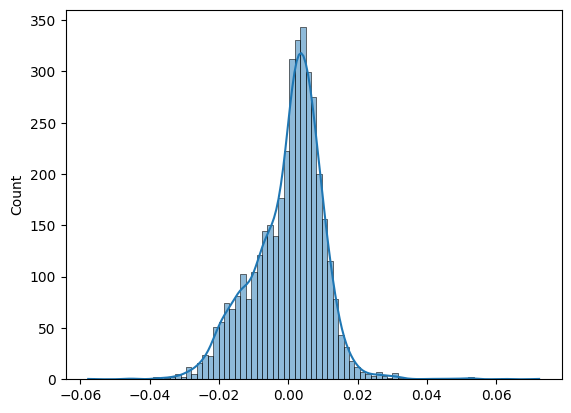

In [16]:
residuals = model.resid
sns.histplot(residuals, kde = True)

Part II.

We will now investigate the residuals of the model to see whether or not we can explain the pattern in the previously unknown factor of regression model. 

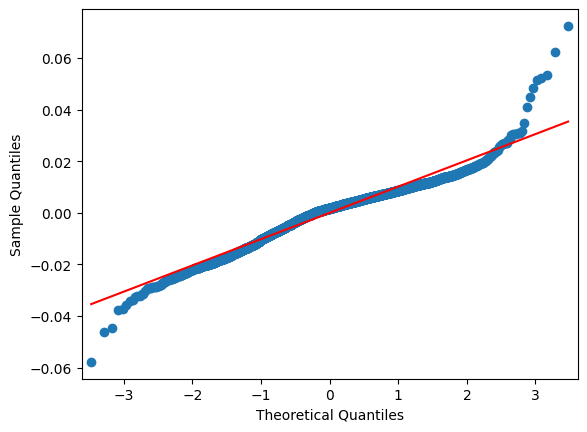

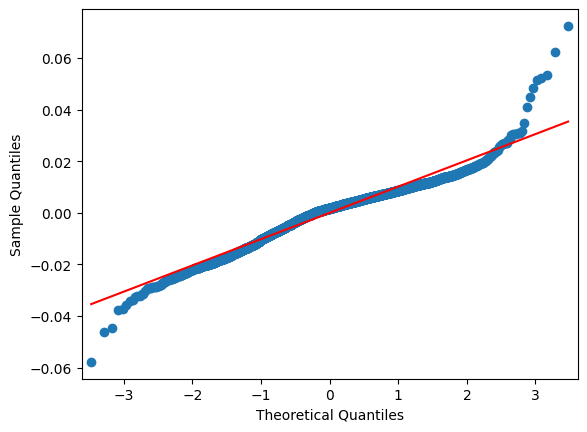

In [17]:
sm.qqplot(residuals, line = 's')

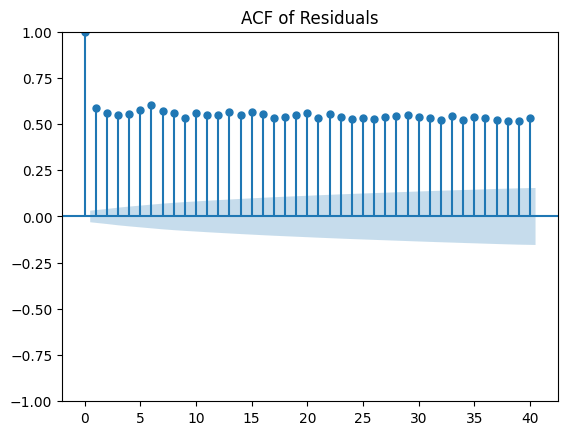

In [18]:
plot_acf(residuals, lags = 40)
plt.title("ACF of Residuals")
plt.show()

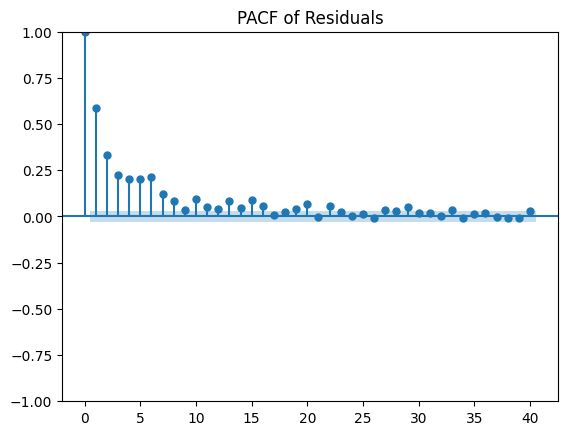

In [19]:
plot_pacf(residuals, lags = 40)
plt.title("PACF of Residuals")
plt.show()

Observing the ACF and PACF Model, we can see that they both trail off. This means that the residual can be modelled via an ARMA(p,q) process. 

In [20]:
arma_model = ARIMA(residuals, order = (1,0,1))
fit = arma_model.fit()
print(fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3920
Model:                 ARIMA(1, 0, 1)   Log Likelihood               13847.855
Date:                Thu, 06 Nov 2025   AIC                         -27687.709
Time:                        11:59:11   BIC                         -27662.614
Sample:                             0   HQIC                        -27678.805
                               - 3920                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.938e-05      0.001     -0.096      0.924      -0.001       0.001
ar.L1          0.9645      0.004    261.670      0.000       0.957       0.972
ma.L1         -0.8098      0.009    -91.965      0.0

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [24]:
X_test = data_test[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]
X_test = sm.add_constant(X_test)
Y_test = data_test['Excess']     

In [ ]:
R_hat_factors = model.predict(X_test)

3920    0.001401
3921   -0.006675
3922   -0.001682
3923   -0.004473
3924    0.001497
3925   -0.007485
3926    0.007128
3927   -0.002829
3928   -0.000392
3929   -0.010910
3930   -0.005099
3931   -0.002766
3932   -0.005379
3933   -0.009581
3934    0.012013
3935   -0.005874
3936   -0.000418
3937   -0.002486
3938   -0.003312
dtype: float64

In [30]:
R_hat_residuals = fit.forecast(steps=len(X_test)) 

In [31]:
R_hat_total = R_hat_factors.values + R_hat_residuals.values

In [ ]:
mae = mean_absolute_error(Y_test, R_hat_total)
rmse = np.sqrt(mean_squared_error(Y_test, R_hat_total))

print(f"MAE: {mae:.6f}")
print(f"RMSE: {rmse:.6f}")

MAE: 0.008773
RMSE: 0.013041


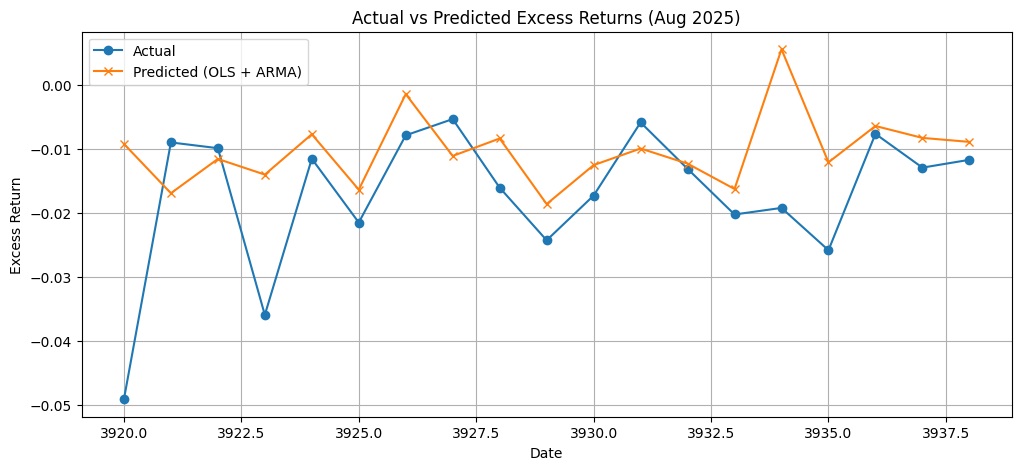

In [34]:
plt.figure(figsize=(12, 5))
plt.plot(Y_test.index, Y_test, label='Actual', marker='o')
plt.plot(Y_test.index, R_hat_total, label='Predicted (OLS + ARMA)', marker='x')
plt.title("Actual vs Predicted Excess Returns (Aug 2025)")
plt.xlabel("Date")
plt.ylabel("Excess Return")
plt.legend()
plt.grid(True)
plt.show()